# Breaking down $k$-means

In this tutorial we will be examining Lloyd's algorithm for $k$-means clustering. Specifically, we will be looking at datasets restricted to the plane.

This tutorial has been adapted from the case study in the publication associated with this library [[WKG20]](../../reference/bibliography.rst).

## Formulation

In our case, we have a two-dimensional dataset with between 20 and 60 rows taken from the unit interval that must be split into three parts, i.e. we will be clustering each dataset using $k$-means with $k=3$.

The fitness of an individual will be determined by the final inertia of the clustering. The inertia is the within-cluster sum-of-squares and has an optimal value of zero.

However, given that $k$-means is stochastic, we will use some [smoothing](../discussion/smoothing.rst) to counteract this effect and get a more reliable fitness score.

In [1]:
import edo
import numpy as np
from edo.distributions import Uniform
from sklearn.cluster import KMeans

In [2]:
def fitness(individual, num_trials):

    inertias, labels = [], []
    for seed in range(num_trials):
        km = KMeans(n_clusters=3, random_state=seed).fit(individual.dataframe)
        inertias.append(km.inertia_)
        labels.append(km.labels_)

    individual.labels = labels[np.argmin(inertias)]
    return np.min(inertias)

In [3]:
Uniform.param_limits["bounds"] = [0, 1]

opt = edo.DataOptimiser(
    fitness,
    size=50,
    row_limits=[10, 50],
    col_limits=[2, 2],
    families=[edo.Family(Uniform)],
    max_iter=5,
    best_prop=0.1,
)

pop_history, fit_history = opt.run(random_state=0, kwargs={"num_trials": 5})

## Visualising the results

As always, we can plot the fitness progression to get an idea of how far the EA has taken us.

In [4]:
import matplotlib.pyplot as plt

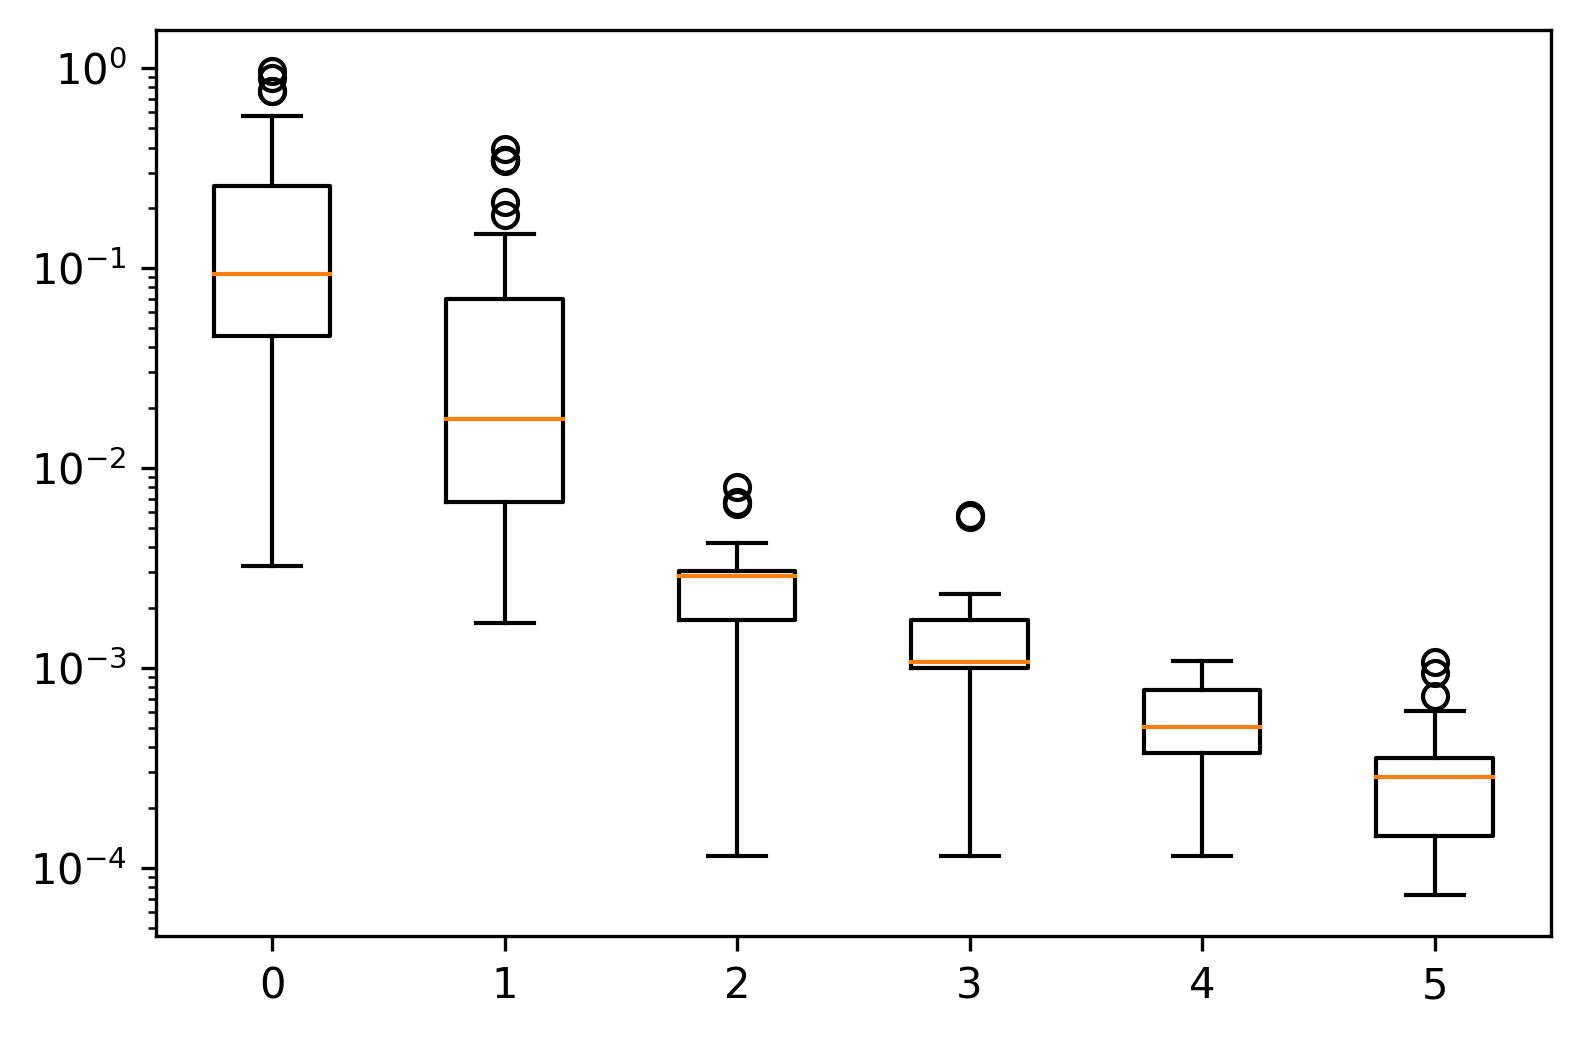

In [5]:
_, ax = plt.subplots(dpi=300)

ax.set_yscale("log")

for epoch, data in fit_history.groupby("generation"):

    ax.boxplot(data["fitness"], positions=[epoch], widths=0.5)

So, yes, we are moving toward that optimal value. However, an inertia of zero would be the trivial case where the three clusters are simply three unique points stacked on top of one another.

Knowing that we are in the right ballpark, it might be of use to study some individuals that were created.

Below are the individuals representing the best to worst fitnesses at regular intervals of 25 percentiles.

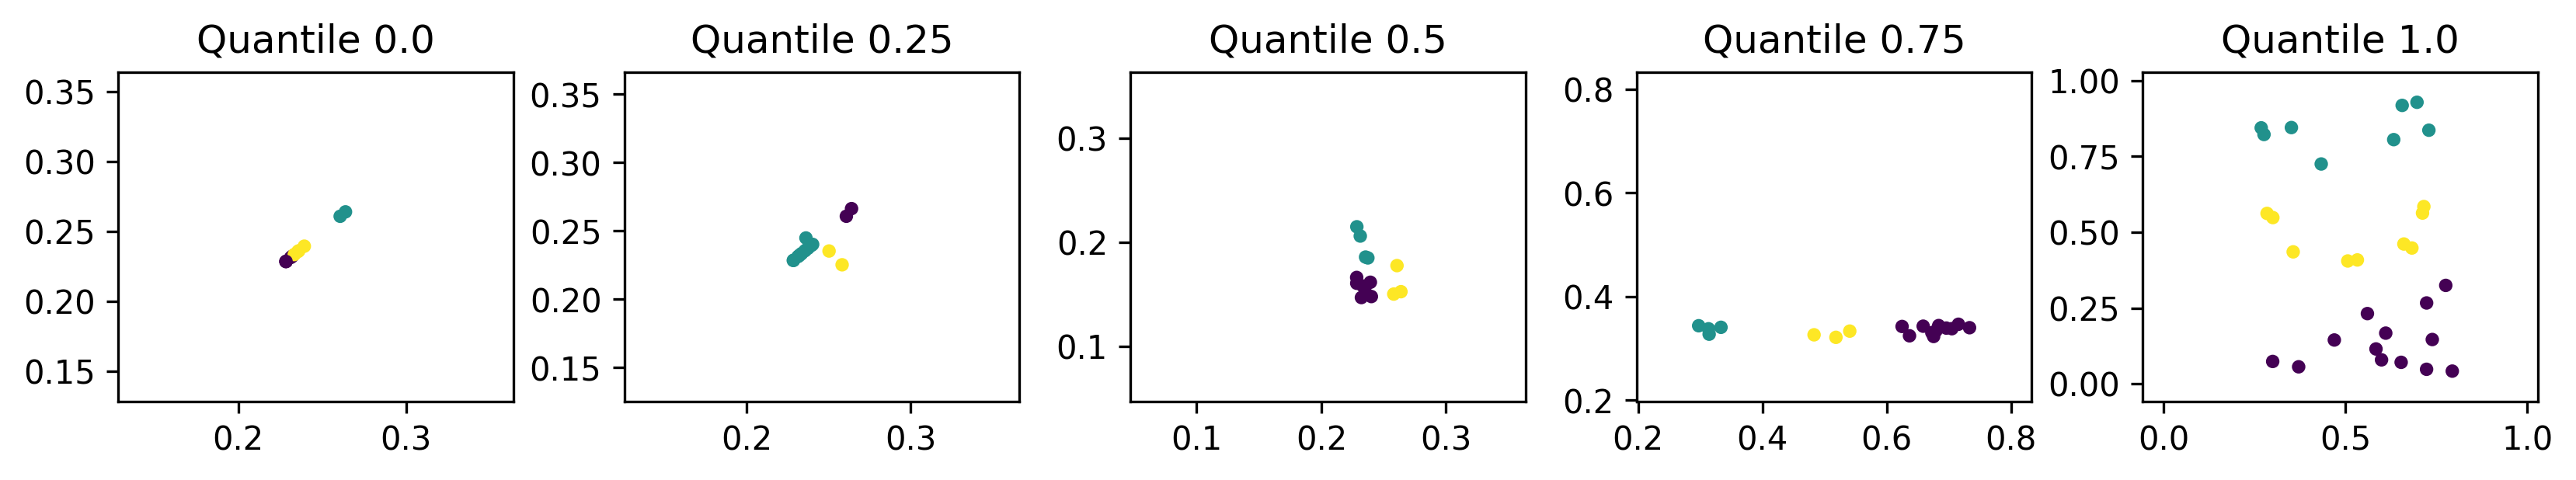

In [6]:
_, axes = plt.subplots(1, 5, figsize=(11, 2), dpi=300)

for quantile, ax in zip((0.0, 0.25, 0.5, 0.75, 1.0), axes):

    idx = (fit_history["fitness"] - fit_history["fitness"].quantile(quantile)).abs().idxmin()
    gen, ind = fit_history[["generation", "individual"]].iloc[idx]

    individual = pop_history[gen][ind]

    xs, ys = individual.dataframe[0], individual.dataframe[1]
    ax.scatter(xs, ys, c=individual.labels, s=10)

    lims = min(min(xs), min(ys)) - 0.1, max(max(xs), max(ys)) + 0.1
    
    ax.set(xlim=lims, ylim=lims, title=f"Quantile {quantile}")

plt.tight_layout(pad=0.5)

We can see here that the less-fit individuals are more dispersed and utilise more of the search space, while fitter individuals are more compact.

Low dispersion *within* clusters is to be expected since inertia measures within-cluster coherence. However, low dispersion *between* clusters is not necessarily something we want. It may be that this is a coincidence but could also be a limitation of our fitness function. In any case, this can be mitigated against by changing the fitness function to, say, the [silhouette coefficient](https://en.wikipedia.org/wiki/Silhouette_(clustering)).

Another interesting point is that the fittest individuals seem to have reduced the dimension of the search space to one dimension

A simple way of doing this is to have two columns that are copies of one another as in the leftmost plot. By removing one dimension, the $k$-means algorithm is more easily able to find a [centroidal Voronoi tessellation](https://en.wikipedia.org/wiki/Centroidal_Voronoi_tessellation) which is its aim overall. To mitigate against this, the fitness function could be adjusted to penalise datasets with high positive correlation.

These kind of adjustments and considerations are required to deeply study an algorithm or method with EDO.